In [4]:
# --- Stefan AEI Downscaling – Corrected Step-by-Step AEI Logic ----------------
# Enforces: Step 1–7 only if GMIA > 0, Step 8–10 for GMIA == 0, proper hybrid scaling, land caps per step

import os
import numpy as np
import pandas as pd
import rasterio
import rasterio.mask
import geopandas as gpd
from rasterio.enums import Resampling
from rasterio.warp import reproject
from shapely.geometry import mapping

# ─────── user configuration ──────────────────────────────────────────────────
base_dir = r"E:/Recovered_15_57_11/My Passport(F)/MIRCA 2020/input"
scenarios = ["base", "low", "upper", "hyde_base", "hyde_low", "hyde_upper"]
years = [2005]

paths = {
    "gmia": {
        2005: os.path.join(base_dir, "GMIA", "GMIA_2005.tif"),
        2010: os.path.join(base_dir, "GMIA", "GMIA_2010.tif"),
        2015: os.path.join(base_dir, "GMIA", "GMIA_2015.tif"),
    },
    "land": os.path.join(base_dir, "Stefan", "LAND_GMIA.tif"),
    "aei_csv": os.path.join(base_dir, "AEI", "Global", "New AEI GLobal", "Final AEI", "FInal"),
    "shp": os.path.join(base_dir, "AEI", "Shapefile", "new Shapefile", "Piyushs"),
    "out": os.path.join(base_dir, "..", "Output", "Global", "GMIA"),
}
os.makedirs(paths["out"], exist_ok=True)

# ─────── helper functions ────────────────────────────────────────────────
def mask_raster(raster_path, geometry, out_shape, base_transform, base_crs):
    with rasterio.open(raster_path) as src:
        src_crs = src.crs if src.crs else base_crs
        img, src_tr = rasterio.mask.mask(src, [mapping(geometry)], crop=False)
        data = np.nan_to_num(img[0].astype(np.float32), nan=0)
        data[data < 0] = 0
        if data.shape == out_shape and src_tr == base_transform and src_crs == base_crs:
            return data
        resampled = np.zeros(out_shape, dtype=np.float32)
        reproject(data, resampled, src_transform=src_tr, src_crs=src_crs,
                  dst_transform=base_transform, dst_crs=base_crs, resampling=Resampling.bilinear)
        return resampled

def stefan_allocate(aei_target, irri_t1, crop, pasture, land):
    agri = crop + pasture
    allocated = np.zeros_like(irri_t1)
    stepwise_alloc = []
    gmia_mask = irri_t1 > 0

    step_funcs = [
        lambda: np.minimum(irri_t1, crop),
        lambda: np.minimum(irri_t1, agri),
        lambda: np.minimum(irri_t1, land),
        lambda: irri_t1,
        lambda: np.maximum(irri_t1, crop),
        lambda: np.maximum(irri_t1, agri),
        lambda: land,
        lambda: np.where(irri_t1 == 0, crop, np.maximum(irri_t1, agri)),
        lambda: np.maximum(irri_t1, agri),
        lambda: np.maximum(irri_t1, land),
    ]

    for i, step_fn in enumerate(step_funcs):
        if i < 7:
            mask = np.where(gmia_mask, step_fn(), 0)
        else:
            mask = np.where(~gmia_mask, step_fn(), 0)

        limit = np.minimum(mask, land)
        inc = np.clip(limit - allocated, 0, None)
        avail = inc.sum()

        if avail <= 0:
            stepwise_alloc.append(0)
            continue

        if aei_target <= avail:
            rel = aei_target * 0.5
            abs_ = aei_target * 0.5
            weights = inc / (avail + 1e-6)
            allocated += weights * rel
            allocated += (inc > 0) * (abs_ / np.count_nonzero(inc))
            stepwise_alloc.append(aei_target)
            aei_target = 0
            break

        allocated += inc
        stepwise_alloc.append(avail)
        aei_target -= avail

        # Enforce land limit after each step
        allocated = np.minimum(allocated, land)

    while len(stepwise_alloc) < 10:
        stepwise_alloc.append(0)

    total_alloc = allocated.sum()
    if total_alloc > 0 and abs(total_alloc - sum(stepwise_alloc)) > 1e-3:
        allocated *= (sum(stepwise_alloc) / total_alloc)

    return allocated, stepwise_alloc

# ─────── load constants ────────────────────────────────────────────────
ref_year = years[0]
with rasterio.open(paths["gmia"][ref_year]) as src:
    gmia_base = src.read(1)
    meta = src.meta.copy()
    transform, crs = src.transform, src.crs
    full_shape = gmia_base.shape

# ─────── main processing ────────────────────────────────────────────────
for scen in scenarios:
    hyde_mode = scen.startswith("hyde")
    scen_clean = scen.replace("hyde_", "")

    for yr in years:
        print(f"\n▶ Processing year {yr} | scenario {scen}")
        shp_fp = os.path.join(paths["shp"], f"AEI_{yr}_2.shp")
        shp = gpd.read_file(shp_fp).to_crs(crs)
        shp["unit_code"] = shp["unit_code"].astype(str)

        stats_fp = os.path.join(paths["aei_csv"], f"AEI_{yr}_Global.xlsx")
        stats = pd.read_excel(stats_fp)
        stats["unit_code"] = stats["unit_code"].astype(str)

        df = shp.merge(stats, on="unit_code", how="inner")

        crop_fp = os.path.join(base_dir, "hyde", scen_clean, f"cropland{yr}AD.tif")
        past_fp = os.path.join(base_dir, "hyde", scen_clean, f"pasture{yr}AD.tif")

        mosaic = np.zeros(full_shape, dtype=np.float32)
        debug = []

        for _, row in df.iterrows():
            uc = row.unit_code
            target = float(row.AEI)
            if target <= 0 or row.geometry.is_empty:
                continue
            geom = row.geometry.buffer(0)

            irri_prev = np.zeros(full_shape, dtype=np.float32)
            if not hyde_mode:
                irri_prev = mask_raster(paths["gmia"][yr], geom, full_shape, transform, crs)

            crop = mask_raster(crop_fp, geom, full_shape, transform, crs) * 100
            past = mask_raster(past_fp, geom, full_shape, transform, crs) * 100
            land = mask_raster(paths["land"], geom, full_shape, transform, crs) 

            alloc, steps = stefan_allocate(target, irri_prev, crop, past, land)
            mosaic += alloc

            debug.append({"unit_code": uc, "target_AEI": target, "allocated_AEI": float(alloc.sum()),
                          **{f"step_{i+1}": s for i, s in enumerate(steps)}})

        ras_out = os.path.join(paths["out"], f"AEI_{yr}_{scen}.tif")
        meta.update(dtype=rasterio.float32, nodata=-9)
        mosaic = np.nan_to_num(mosaic, nan=0, posinf=0, neginf=0)
        with rasterio.open(ras_out, "w", **meta) as dst:
            dst.write(mosaic, 1)

        dbg_df = pd.DataFrame(debug)
        dbg_df["diff"] = dbg_df.allocated_AEI - dbg_df.target_AEI
        dbg_out = os.path.join(paths["out"], f"debug_{yr}_{scen}.csv")
        dbg_df.to_csv(dbg_out, index=False)

        print(f"  ➔ written raster: {ras_out}\n    ➞ debug CSV : {dbg_out}")



▶ Processing year 2005 | scenario base
  ➔ written raster: E:/Recovered_15_57_11/My Passport(F)/MIRCA 2020/input\..\Output\Global\GMIA\AEI_2005_base.tif
    ➞ debug CSV : E:/Recovered_15_57_11/My Passport(F)/MIRCA 2020/input\..\Output\Global\GMIA\debug_2005_base.csv

▶ Processing year 2005 | scenario low
  ➔ written raster: E:/Recovered_15_57_11/My Passport(F)/MIRCA 2020/input\..\Output\Global\GMIA\AEI_2005_low.tif
    ➞ debug CSV : E:/Recovered_15_57_11/My Passport(F)/MIRCA 2020/input\..\Output\Global\GMIA\debug_2005_low.csv

▶ Processing year 2005 | scenario upper
  ➔ written raster: E:/Recovered_15_57_11/My Passport(F)/MIRCA 2020/input\..\Output\Global\GMIA\AEI_2005_upper.tif
    ➞ debug CSV : E:/Recovered_15_57_11/My Passport(F)/MIRCA 2020/input\..\Output\Global\GMIA\debug_2005_upper.csv

▶ Processing year 2005 | scenario hyde_base
  ➔ written raster: E:/Recovered_15_57_11/My Passport(F)/MIRCA 2020/input\..\Output\Global\GMIA\AEI_2005_hyde_base.tif
    ➞ debug CSV : E:/Recovered_1

C:\Users\endal\AppData\Local\Temp\ipykernel_27444\4174187822.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_bar.set_xticklabels(labels, fontsize=16)
C:\Users\endal\AppData\Local\Temp\ipykernel_27444\4174187822.py:124: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_bar.set_yticklabels([f'{int(t)}%' for t in ax_bar.get_yticks()], fontsize=16)


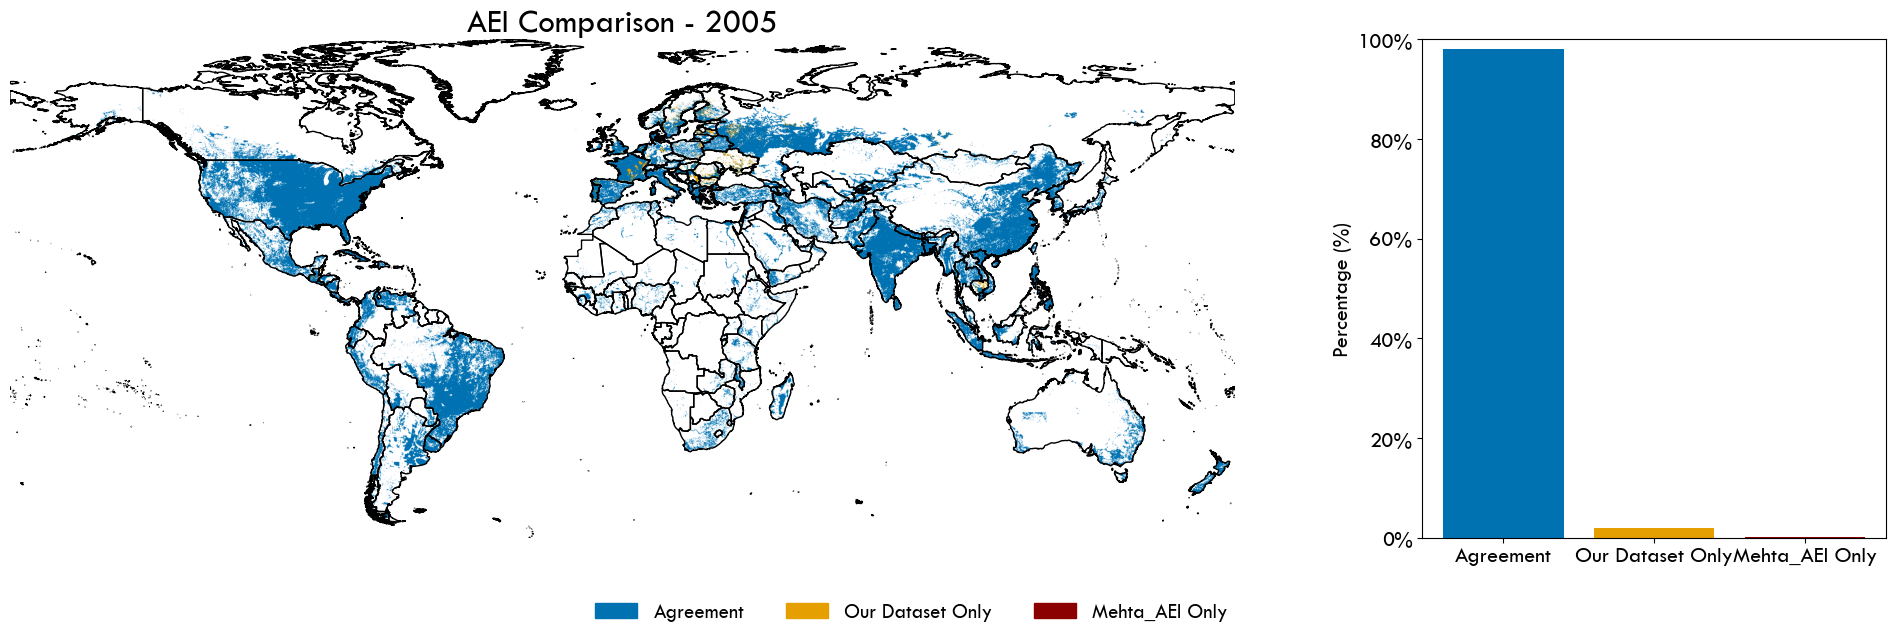

In [7]:
import os
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.patches as mpatches
from rasterio.warp import reproject, Resampling
from rasterio.mask import mask
from matplotlib import font_manager

# === FILE PATHS ===
our_raster_path = r"E:\Recovered_15_57_11\My Passport(F)\MIRCA 2020\Output\Global\GMIA\AEI_2005_base.tif"
mehta_raster_path = r"D:\PhD_Udel\MICRA_2015\DOwnscaling\India\FInal_Downscaling\2005\AEI_05.tif"
shapefile_path = r"D:\PhD_Udel\Other Projects\Review Papaer\WB_countries_Admin0_10m\WB_countries_Admin0_10m.shp"
# output_map_path = "E:\\Brazil Validation\\Final Maps\\AEI_Comparison_2015.png"
# output_raster_path = "E:\\Brazil Validation\\AEI_Output\\AEI_2015.tif"

# === COLORS ===
dark_blue = '#0072B2'  # Agreement
orange = '#E69F00'     # Our dataset only
dark_red = '#8B0000'   # Mehta_AEI only

# === FONTS ===
if 'Tw Cen MT' not in [f.name for f in font_manager.fontManager.ttflist]:
    print('"Tw Cen MT" font not found. Using default.')
    title_font = 'sans-serif'
else:
    title_font = 'Tw Cen MT'

# === UTILITY FUNCTIONS ===
def clip_raster_with_shape(raster_path, shapefile_gdf):
    with rasterio.open(raster_path) as src:
        shapefile_gdf = shapefile_gdf.to_crs(src.crs)  # Match CRS
        geometry = [feature["geometry"] for feature in shapefile_gdf.__geo_interface__['features']]
        out_image, out_transform = mask(src, geometry, crop=True)
        return out_image[0], out_transform, src.crs

def reproject_and_resample(src_data, src_transform, src_crs, dst_shape, dst_transform, dst_crs):
    dst_data = np.zeros(dst_shape, dtype=src_data.dtype)
    reproject(
        source=src_data,
        destination=dst_data,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=Resampling.nearest
    )
    return dst_data, dst_transform

def clean_raster_data(raster_data, threshold=0):
    return np.where(raster_data < threshold, np.nan, raster_data)

def get_extent(transform, width, height):
    left = transform[2]
    top = transform[5]
    right = left + transform[0] * width
    bottom = top + transform[4] * height
    return (left, right, bottom, top)

def calculate_percentages(agree, our_only, mehta_only):
    agree_count = np.sum(agree)
    our_only_count = np.sum(our_only)
    mehta_only_count = np.sum(mehta_only)
    total = agree_count + our_only_count + mehta_only_count
    return [
        (agree_count / total) * 100 if total > 0 else 0,
        (our_only_count / total) * 100 if total > 0 else 0,
        (mehta_only_count / total) * 100 if total > 0 else 0,
    ]

# === MAIN PROCESS ===
# Load shapefile
world = gpd.read_file(shapefile_path).to_crs(epsg=4326)

# Clip both rasters using the shapefile extent
raster_our, transform_our, crs_our = clip_raster_with_shape(our_raster_path, world)
raster_mehta, transform_mehta, crs_mehta = clip_raster_with_shape(mehta_raster_path, world)

# Reproject both to WGS84 if needed
if crs_our != 'EPSG:4326':
    raster_our, transform_our = reproject_and_resample(raster_our, transform_our, crs_our, raster_our.shape, transform_our, 'EPSG:4326')
if crs_mehta != 'EPSG:4326':
    raster_mehta, transform_mehta = reproject_and_resample(raster_mehta, transform_mehta, crs_mehta, raster_our.shape, transform_our, 'EPSG:4326')

# Ensure alignment
raster_mehta_resampled, _ = reproject_and_resample(
    raster_mehta, transform_mehta, crs_mehta, raster_our.shape, transform_our, 'EPSG:4326'
)

# Clean and mask
raster_our = clean_raster_data(raster_our)
raster_mehta_resampled = clean_raster_data(raster_mehta_resampled)

# Binary agreement logic
agree = (raster_our > 0) & (raster_mehta_resampled > 0)
our_only = (raster_our > 0) & ((raster_mehta_resampled == 0) | np.isnan(raster_mehta_resampled))
mehta_only = (raster_mehta_resampled > 0) & ((raster_our == 0) | np.isnan(raster_our))

# Create RGB image
combined_rgb = np.ones((raster_our.shape[0], raster_our.shape[1], 3))
combined_rgb[agree] = np.array([0, 114, 178]) / 255
combined_rgb[our_only] = np.array([230, 159, 0]) / 255
combined_rgb[mehta_only] = np.array([139, 0, 0]) / 255

# Plotting
fig, (ax_map, ax_bar) = plt.subplots(1, 2, figsize=(20, 6), dpi=100, gridspec_kw={'width_ratios': [3, 1]})
extent = get_extent(transform_our, raster_our.shape[1], raster_our.shape[0])
ax_map.imshow(combined_rgb, extent=extent)
ax_map.set_title('AEI Comparison - 2005', fontsize=24, fontname=title_font)
ax_map.set_xticks([])
ax_map.set_yticks([])
ax_map.set_frame_on(False)
world.boundary.plot(ax=ax_map, linewidth=1, edgecolor='black')

# Bar Chart
percentages = calculate_percentages(agree, our_only, mehta_only)
labels = ['Agreement', 'Our Dataset Only', 'Mehta_AEI Only']
colors = [dark_blue, orange, dark_red]
ax_bar.bar(labels, percentages, color=colors)
ax_bar.set_ylabel('Percentage (%)', fontsize=16)
ax_bar.set_ylim(0, 100)
ax_bar.set_xticklabels(labels, fontsize=16)
ax_bar.set_yticklabels([f'{int(t)}%' for t in ax_bar.get_yticks()], fontsize=16)

# Add legend
legend_elements = [
    mpatches.Patch(color=dark_blue, label='Agreement'),
    mpatches.Patch(color=orange, label='Our Dataset Only'),
    mpatches.Patch(color=dark_red, label='Mehta_AEI Only')
]
plt.figlegend(handles=legend_elements, loc='lower center', ncol=3, fontsize=15, frameon=False, bbox_to_anchor=(0.5, -0.05))
plt.tight_layout(rect=[0, 0.05, 1, 1])

# Save final figure
# plt.savefig(output_map_path, bbox_inches='tight')
plt.show()

# Optional: Save AEI agreement as raster
# with rasterio.open(
#     output_raster_path,
#     'w',
#     driver='GTiff',
#     height=agree.shape[0],
#     width=agree.shape[1],
#     count=1,
#     dtype='uint8',
#     crs='EPSG:4326',
#     transform=transform_our,
#     compress='lzw',
#     nodata=0
# ) as dst:
#     dst.write(agree.astype('uint8'), 1)


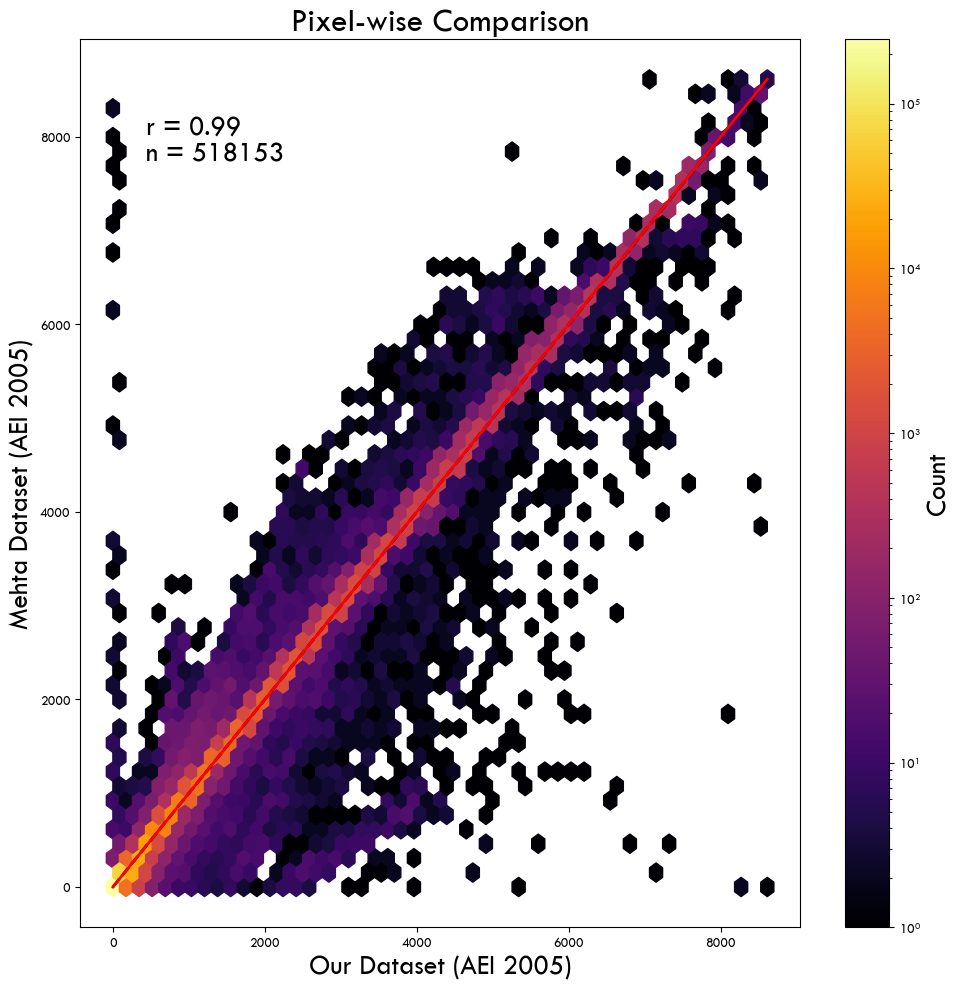

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.mask import mask
from scipy.stats import linregress, pearsonr

# === INPUT FILES ===
our_raster_path = r"E:\Recovered_15_57_11\My Passport(F)\MIRCA 2020\Output\Global\GMIA\AEI_2005_base.tif"
mehta_raster_path =  r"D:\PhD_Udel\MICRA_2015\DOwnscaling\India\FInal_Downscaling\2005\AEI_05.tif"

# === PLOT SETTINGS ===
plt.rcParams['font.family'] = 'Tw Cen MT'
font_size = 20
nan_value = 0  # Value treated as NoData

# === CLEANING FUNCTION ===
def clean_raster_data(raster_data, nan_value):
    raster_data = np.where(raster_data == nan_value, np.nan, raster_data)
    raster_data = np.where(raster_data < 0, np.nan, raster_data)
    return raster_data

# === SCATTER PLOT FUNCTION ===
def plot_scatter_and_regression(x, y, label_x, label_y):
    fig, ax = plt.subplots(figsize=(10, 10))
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    n_valid = len(x)
    r, _ = pearsonr(x, y)

    common_min = min(np.nanmin(x), np.nanmin(y))
    common_max = max(np.nanmax(x), np.nanmax(y))

    hb = ax.hexbin(x, y, gridsize=50, cmap='inferno', bins='log',
                   extent=(common_min, common_max, common_min, common_max))
    cbar = fig.colorbar(hb, ax=ax)
    cbar.set_label('Count', fontsize=font_size)

    ax.plot([common_min, common_max], [common_min, common_max], color='black', linestyle='--', linewidth=2)
    slope, intercept, *_ = linregress(x, y)
    ax.plot([common_min, common_max],
            [intercept + slope * common_min, intercept + slope * common_max],
            color='red', linewidth=2)

    ax.text(common_min + 0.05*(common_max-common_min),
            common_max - 0.1*(common_max-common_min),
            f'r = {r:.2f}\nn = {n_valid}',
            fontsize=font_size, backgroundcolor='white')

    ax.set_xlabel(label_x, fontsize=font_size)
    ax.set_ylabel(label_y, fontsize=font_size)
    ax.set_title('Pixel-wise Comparison', fontsize=font_size + 4)
    plt.tight_layout()
    plt.show()

# === MAIN COMPARISON ===
with rasterio.open(our_raster_path) as src1:
    our_data = clean_raster_data(src1.read(1), nan_value)
    our_meta = src1.meta.copy()

    with rasterio.open(mehta_raster_path) as src2:
        # Prepare a target array for reprojection
        mehta_resampled = np.empty_like(our_data)

        reproject(
            source=rasterio.band(src2, 1),
            destination=mehta_resampled,
            src_transform=src2.transform,
            src_crs=src2.crs,
            dst_transform=src1.transform,
            dst_crs=src1.crs,
            resampling=Resampling.bilinear
        )

        mehta_data = clean_raster_data(mehta_resampled, nan_value)

# === Flatten and Compare ===
our_flat = our_data.flatten()
mehta_flat = mehta_data.flatten()

plot_scatter_and_regression(our_flat, mehta_flat,
                             label_x='Our Dataset (AEI 2005)',
                             label_y='Mehta Dataset (AEI 2005)')
